In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import collections
import surprise
from collections import Counter
from math import sqrt
from collections import defaultdict

from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import KNNBasic
from sklearn.metrics import roc_curve , auc

data_ratings = pd.read_csv('ratings.csv',delimiter=',', names = ['user_id', 'item_id', 'rating', 'timestamp'], header=0)
user_ids = list(data_ratings.user_id)
movie_ids = list(data_ratings.item_id)
rating_ids=list(data_ratings.rating)
user_vs_movie_ratings = data_ratings.pivot_table(index=['user_id'],columns=['item_id'],values='rating',fill_value=0).values
read = surprise.reader.Reader(line_format=u'user item rating timestamp', sep=',',  skip_lines=1, rating_scale=(0.5, 5))
data_load = surprise.Dataset.load_from_file(file_path='ratings.csv',reader=read)
count_movie = Counter(movie_ids)
count_usr_rating = Counter(user_ids)

In [2]:
# Question 1: Compute sparsity of movie rating dataset

def sparsity():
    total_ratings_count = user_vs_movie_ratings.shape[0] * user_vs_movie_ratings.shape[
        1]  # total number of users * total number of movies    #R.shape[0] * R.shape[1]
    available_ratings_count = data_ratings.shape[0]  # total number of ratings available    #df.shape[0]
    sparsity = float(available_ratings_count) / float(total_ratings_count)
    #print('Sparsity of the dataset: ', sparsity)


sparsity()

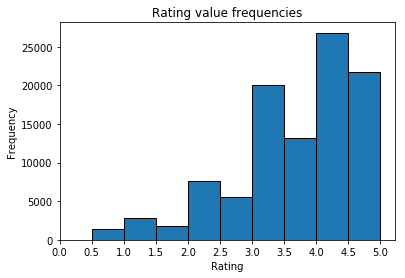

In [3]:
# Question 2:  Histogram of rating counts

def ratingsHistogram():
    ratings = data_ratings.iloc[0:data_ratings.shape[0], 2]
    plt.hist(ratings, ec='black', bins=9)  # , bins=10)#, bins=[0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
    plt.title("Rating value frequencies")
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.xticks(np.arange(0, 5.5, 0.5))
    #plt.show()


ratingsHistogram()

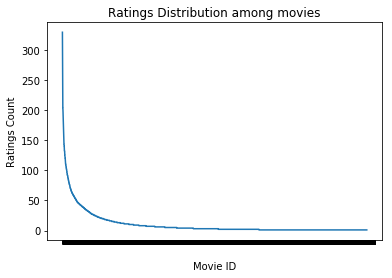

In [52]:
# Question 3:

def ratingDistribution():
    movie_ids_2 = list()
    ratings_count = list()
    for i in sorted(count_movie, key=count_movie.get, reverse=True):
        movie_ids_2.append(i)
        ratings_count.append(count_movie[i])

    plt.plot(ratings_count)
    plt.title("Ratings Distribution among movies")
    plt.xlabel("Movie ID")
    plt.ylabel("Ratings Count")
    plt.xticks(range(10000), " ")
    #plt.show()
    return movie_ids_2, ratings_count


movie_ids_2, ratings_count = ratingDistribution()


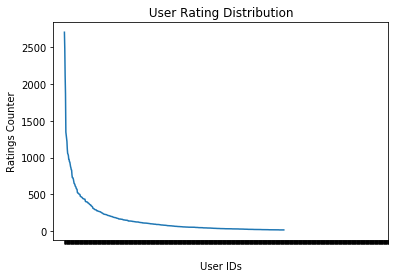

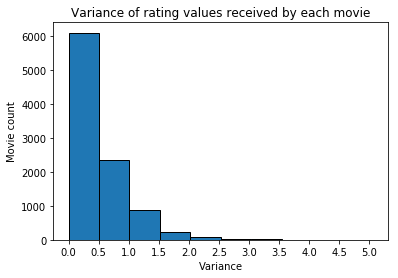

In [6]:
# Question 6

def varianceHistogram():
    data = zip(movie_ids, rating_ids)
    data2 = collections.defaultdict(list)
    for movie, rating in data:
        data2[movie].append(rating)

    movie_list = []
    variance_list = []
    for i in data2.keys():
        movie_list.append(i)
        variance_list.append(np.var(data2[i]))

    plt.hist(variance_list, bins=10, ec='black')
    plt.title("Variance of rating values received by each movie")
    plt.xlabel("Variance")
    plt.ylabel("Movie count")
    plt.xticks(np.arange(0, 5.5, 0.5))
    #plt.show()
    return variance_list


vars = varianceHistogram()

In [4]:
# Question 10

def KPlots(matrix):
    test_rmse = []
    test_mae = []
    k = range(2, 102, 2)
    for i in k:
        print(i)
        knn = surprise.prediction_algorithms.knns.KNNWithMeans(k=i, sim_options={'name': 'pearson', 'user_based': True})
        knn_output = surprise.model_selection.cross_validate(knn, matrix, measures=['RMSE', 'MAE'], cv=10, verbose=False)
        rmse = knn_output['test_rmse']
        mae = knn_output['test_mae']
        test_rmse.append(sum(rmse) / 10.0)
        test_mae.append(sum(mae) / 10.0)
    print("\n\nK values: ", k)
    print("\n\nAverage RMSE Values: ", test_rmse)
    print("\n\nAverage MAE Values", test_mae)
    plt.plot(k, test_rmse)
    plt.xlabel('K')
    plt.ylabel('Average RMSE')
    plt.show()
    plt.plot(k, test_mae)
    plt.xlabel('K')
    plt.ylabel('Average MAE')
    plt.show()
    return test_rmse, test_mae

def NNMFPlots(matrix):
    test_rmse = []
    test_mae = []
    k = range(2, 52, 2)
    for i in k:
        print(i)
        nnmf = surprise.prediction_algorithms.matrix_factorization.NMF(n_factors=i)
        nnmf_output = surprise.model_selection.cross_validate(nnmf, matrix, measures=['RMSE', 'MAE'], cv=10, verbose=False)
        rmse = nnmf_output['test_rmse']
        mae = nnmf_output['test_mae']
        test_rmse.append(sum(rmse) / 10.0)
        test_mae.append(sum(mae) / 10.0)
    print("\n\nK values: ", k)
    print("\n\nAverage RMSE Values: ", test_rmse)
    print("\n\nAverage MAE Values", test_mae)
    plt.plot(k, test_rmse)
    plt.xlabel('K')
    plt.ylabel('Average RMSE')
    plt.show()
    plt.plot(k, test_mae)
    plt.xlabel('K')
    plt.ylabel('Average MAE')
    plt.show()
    return test_rmse, test_mae


#test_rmse, test_mae = KPlots(data_load)

In [8]:
# Question 11:

#def stableRMSEandMAE():
 #   for i in range(1, len(test_rmse)):
  #      if (test_rmse[i - 1] - test_rmse[i] <= 0.001) and (test_rmse[i - 1] - test_rmse[
   #         i] > 0):  # and (test_mae[i-1]-test_mae[i] >0) and (test_mae[i-1]-test_mae[i] <= 0.001):
    #        print(2 * i + 1, test_rmse[i - 1] - test_rmse[i], test_rmse[i - 1] - test_rmse[i])


#stableRMSEandMAE()


In [11]:
# Question 12, 13 and 14

def trimmer(typ, matrix, vars , movie_ids_2, ratings_count ):

    if typ == 'popular':
        b = np.less_equal(ratings_count, 2) + 0

    elif typ == 'unpopular':
        b = np.greater(ratings_count, 2) + 0

    elif typ == 'variance':
        c = np.less(ratings_count, 5) + 0
        d = np.less(vars, 2) + 0
        b = np.logical_or(c,d) + 0

    aux = np.multiply(b, movie_ids_2)
    delete_ids = filter(lambda a: a != 0, aux)
    delete_ids = map(str, delete_ids)

    trimatrix = [tup for tup in matrix if not tup[1] in delete_ids]
    return trimatrix

data_knn_popular = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)
data_knn_unpopular = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)
data_knn_variance = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)

data_knn_popular.raw_ratings = trimmer('popular',data_load.raw_ratings, vars , movie_ids_2, ratings_count )
data_knn_unpopular.raw_ratings = trimmer('unpopular',data_load.raw_ratings, vars , movie_ids_2, ratings_count )
data_knn_variance.raw_ratings = trimmer('variance',data_load.raw_ratings, vars , movie_ids_2, ratings_count )

print('KNN for popular')
#KPlots(data_knn_popular)
print('KNN for unpopular')
#KPlots(data_knn_unpopular)
print('KNN for high variance')
#KPlots(data_knn_variance)


NameError: name 'movie_ids_2' is not defined

Computing the pearson similarity matrix...
Done computing similarity matrix.


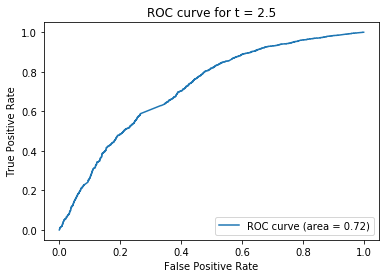

Area under the curve for Threshold = 2 is 0.716601


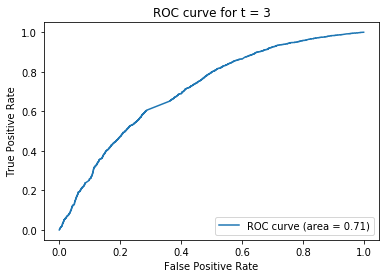

Area under the curve for Threshold = 3 is 0.709681


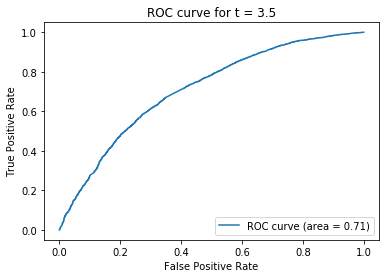

Area under the curve for Threshold = 3 is 0.710121


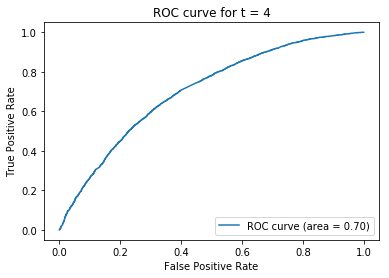

Area under the curve for Threshold = 4 is 0.702716


In [5]:
# Question 15

#knn_output = sp.model_selection.cross_validate(knn, matrix, measures=['RMSE', 'MAE'], cv=10, verbose=False)

data_load = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)
trainset, testset = train_test_split(data_load, test_size=.10)
model = KNNBasic(k=30, sim_options={'name': 'pearson', 'user_based': True})
knn = surprise.prediction_algorithms.knns.KNNWithMeans(k=30, sim_options={'name': 'pearson', 'user_based': True})
model.fit(trainset)
predictions = model.test(testset)

def plotROC(testset,predictions):
    thresholds = [2.5, 3, 3.5, 4]
    for threshold in thresholds:
        true = np.greater_equal([tup[2] for tup in testset],threshold)+0
        pred = [tup[3] for tup in predictions]

        fpr, tpr, thresholds = roc_curve(true,pred)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve for t = ' + str(threshold))
        plt.legend(loc="lower right")
        plt.show()

        print ('Area under the curve for Threshold = %d is %f' %(threshold,roc_auc))

plotROC(testset,predictions)

In [11]:
# Quastion 17 and 18

#data_load = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)
#test_rmse, test_mae = NNMFPlots(data_load)

In [12]:
# Question 19, 20 and 21

data_nnmf_popular = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)
data_nnmf_unpopular = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)
data_nnmf_variance = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)

#data_nnmf_popular.raw_ratings = trimmer('popular',data_load.raw_ratings, vars , movie_ids_2, ratings_count )
#data_nnmf_unpopular.raw_ratings = trimmer('unpopular',data_load.raw_ratings, vars , movie_ids_2, ratings_count )
#data_nnmf_variance.raw_ratings = trimmer('variance',data_load.raw_ratings, vars , movie_ids_2, ratings_count )

print('NNMF for popular')
#NNMFPlots(data_knn_popular)
print('NNMF for unpopular')
#NNMFPlots(data_knn_unpopular)
print('NNMF for high variance')
#NNMFPlots(data_knn_variance)

NNMF for popular
NNMF for unpopular
NNMF for high variance


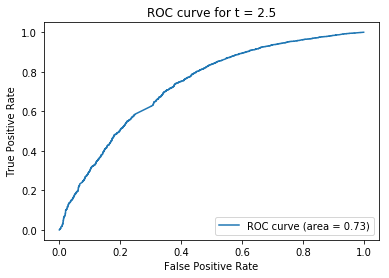

Area under the curve for Threshold = 2 is 0.734027


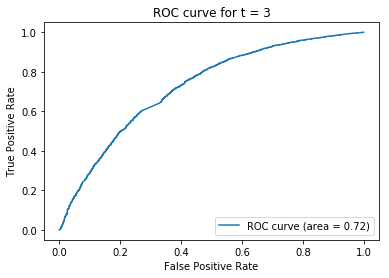

Area under the curve for Threshold = 3 is 0.724424


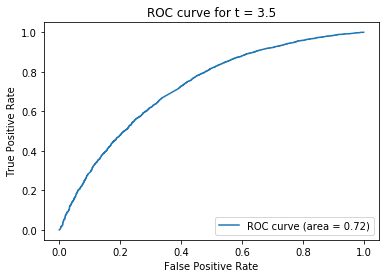

Area under the curve for Threshold = 3 is 0.721254


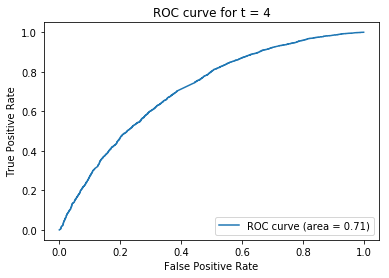

Area under the curve for Threshold = 4 is 0.710365


In [13]:
# Question 22

#data_load = surprise.Dataset.load_from_file(file_path='ratings.csv', reader=read)
#trainset, testset = train_test_split(data_load, test_size=.10)
#model = KNNBasic(k=30, sim_options={'name': 'pearson', 'user_based': True})
nnmf = surprise.prediction_algorithms.matrix_factorization.NMF(n_factors=20)
nnmf.fit(trainset)
predictions = model.test(testset)

plotROC(testset,predictions)

In [8]:
#Question30
import numpy as np
import pandas as pd
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import Reader
from sklearn.metrics import mean_squared_error
from math import sqrt

ratings = pd.read_csv('ratings.csv')
df = pd.DataFrame({'movieID': list(ratings.movieId), 'userID': list(ratings.userId), 'rating': list(ratings.rating)})
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userID', 'movieID', 'rating']], reader)

avg_rating = df.groupby(['userID'])['rating'].mean().tolist()

def naive_collaborative_filter(dataset):
    predictions = [avg_rating[dataset[i][0]-1] for i in range(len(dataset))]
    return predictions

k_rmse = []
kf = KFold(n_splits=10)

for trainset, testset in kf.split(data):
    y_pred = naive_collaborative_filter(testset)
    y_true = [testset[i][2] for i in range(len(testset))]
    k_rmse.append(sqrt(mean_squared_error(y_true,y_pred)))
avg_rmse= np.mean(k_rmse)
print('The average RMSE using naive collaborative filter over 10 folds is', avg_rmse)

The average RMSE using naive collaborative filter over 10 folds is 0.9346986342719557


In [ ]:
#Question 31
k_rmse = []
kf = KFold(n_splits=10)

for trainset, testset in kf.split(data):
    testset = trimmer('popular', testset, vars, movie_ids_2, ratings_count)
    y_pred = naive_collaborative_filter(testset)
    y_true = [testset[i][2] for i in range(len(testset))]
    k_rmse.append(sqrt(mean_squared_error(y_true,y_pred)))
avg_rmse= np.mean(k_rmse)
print('The average RMSE for popular movie trimmed set is',avg_rmse)

In [ ]:
#Question 32
k_rmse = []
kf = KFold(n_splits=10)
data = Dataset.load_from_df(df[['userID', 'movieID', 'rating']], reader)

for trainset, testset in kf.split(data):
    testset = trimmer('unpopular', testset, vars, movie_ids_2, ratings_count)
    y_pred = naive_collaborative_filter(testset)
    y_true = [testset[i][2] for i in range(len(testset))]
    k_rmse.append(sqrt(mean_squared_error(y_true,y_pred)))
avg_rmse= np.mean(k_rmse)
print('The average RMSE for unpopular movie trimmed set is', avg_rmse)

In [ ]:
#Question 33
k_rmse = []
kf = KFold(n_splits=10)
data = Dataset.load_from_df(df[['userID', 'movieID', 'rating']], reader)

for trainset, testset in kf.split(data):
    testset = trimmer('variance', testset, vars, movie_ids_2, ratings_count)
    y_pred = naive_collaborative_filter(testset)
    y_true = [testset[i][2] for i in range(len(testset))]
    k_rmse.append(sqrt(mean_squared_error(y_true,y_pred)))
avg_rmse= np.mean(k_rmse)
print('The average RMSE for high variance movie trimmed set is', avg_rmse)

Computing the pearson similarity matrix...
Done computing similarity matrix.


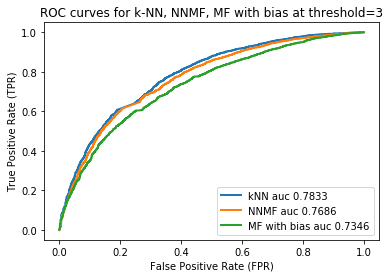

In [80]:
#Question 34
trainset, testset = train_test_split(data, test_size=0.1, random_state=0)
threshold = 3 
models = [surprise.prediction_algorithms.knns.KNNWithMeans(k=20, sim_options = {'name':'pearson'}), surprise.prediction_algorithms.matrix_factorization.NMF(n_factors = 20),
                      surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=20, init_mean = 2.5)]
model_fpr,model_tpr,model_auc = [],[],[]
for model in models:
    model.fit(trainset)
    predictions = model.test(testset)
    
    true = np.greater_equal([tup[2] for tup in testset],threshold)+0
    pred = [tup[3] for tup in predictions]
    
    fpr, tpr, _ = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    model_fpr.append(fpr)
    model_tpr.append(tpr)
    model_auc.append(roc_auc)
    
plt.plot(model_fpr[0], model_tpr[0], lw=2, label='kNN auc %0.4f' %model_auc[0])
plt.plot(model_fpr[1], model_tpr[1], lw=2, label='NNMF auc %0.4f' %model_auc[1])
plt.plot(model_fpr[2], model_tpr[2], lw=2, label='MF with bias auc %0.4f' %model_auc[2])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.title('ROC curves for k-NN, NNMF, MF with bias at threshold=3')
plt.show()

In [1]:
def precision_recall_k(predictions, k=10, threshold=3):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
        
    precisions = dict()
    recalls = dict()
    
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precisions, recalls

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

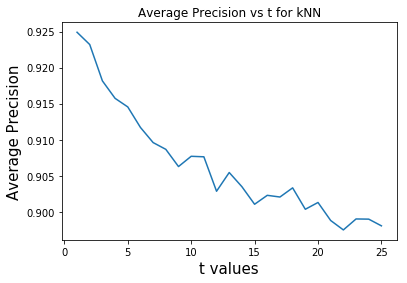

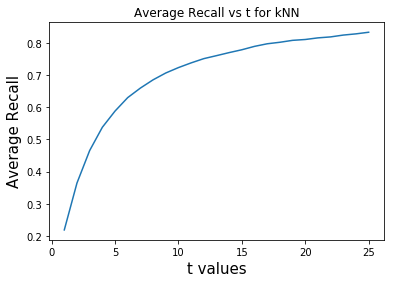

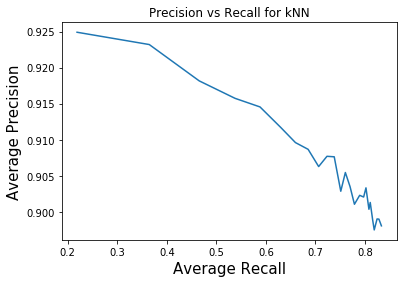

In [86]:
#Quesion 36   
kf = KFold(n_splits=10)
model1 = surprise.prediction_algorithms.knns.KNNWithMeans(k=20, sim_options = {'name':'pearson'}) 
threshold = 3

avg_precision, avg_recall = [], []

for t in range(1, 26): # t from 1 to 25
    t_precision, t_recall = [], []
    for trainset, testset in kf.split(data):
        model1.fit(trainset)
        predictions = model1.test(testset)
        precisions, recalls = precision_recall_k(predictions, k=t, threshold=threshold)
        t_precision.append((sum(prec for prec in precisions.values()) / len(precisions)))
        t_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    avg_precision.append(np.mean(t_precision))
    avg_recall.append(np.mean(t_recall))    

range_t = range(1,26)

plt.plot(range_t, avg_precision)
plt.xlabel('t values', fontsize=15)
plt.ylabel('Average Precision', fontsize=15)
plt.title("Average Precision vs t for kNN")
plt.show()

plt.plot(range_t, avg_recall)
plt.xlabel('t values', fontsize=15)
plt.ylabel('Average Recall', fontsize=15)
plt.title("Average Recall vs t for kNN")
plt.show()

plt.plot(avg_recall, avg_precision)
plt.xlabel('Average Recall', fontsize=15)
plt.ylabel('Average Precision', fontsize=15)
plt.title("Precision vs Recall for kNN")
plt.show()

In [ ]:
#Quesion 37 
kf = KFold(n_splits=10)
model2 = surprise.prediction_algorithms.matrix_factorization.NMF(n_factors=20)
threshold = 3

avg_precision, avg_recall = [], []

for t in range(1, 26): # t from 1 to 25
    t_precision, t_recall = [], []
    for trainset, testset in kf.split(data):
        model2.fit(trainset)
        predictions = model2.test(testset)
        precisions, recalls = precision_recall_k(predictions, k=t, threshold=threshold)
        t_precision.append((sum(prec for prec in precisions.values()) / len(precisions)))
        t_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    avg_precision.append(np.mean(t_precision))
    avg_recall.append(np.mean(t_recall))    


range_t = range(1,26)

plt.plot(range_t, avg_precision)
plt.xlabel('t values', fontsize=15)
plt.ylabel('Average Precision', fontsize=15)
plt.title("Average Precision vs t for NNMF")
plt.show()

plt.plot(range_t, avg_recall)
plt.xlabel('t values', fontsize=15)
plt.ylabel('Average Recall', fontsize=15)
plt.title("Average Recall vs t for NNMF")
plt.show()

plt.plot(avg_recall, avg_precision)
plt.xlabel('Average Recall', fontsize=15)
plt.ylabel('Average Precision', fontsize=15)
plt.title("Precision vs Recall for NNMF")
plt.show()

In [ ]:
kf = KFold(n_splits=10)
model3 = surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=20, init_mean = 3)
threshold = 3

avg_precision, avg_recall = [], []

for t in range(1, 26): # t from 1 to 25
    t_precision, t_recall = [], []
    for trainset, testset in kf.split(data):
        model3.fit(trainset)
        predictions = model3.test(testset)
        precisions, recalls = precision_recall_k(predictions, k=t, threshold=threshold)
        t_precision.append((sum(prec for prec in precisions.values()) / len(precisions)))
        t_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    avg_precision.append(np.mean(t_precision))
    avg_recall.append(np.mean(t_recall))    
    
range_t = range(1,26)

plt.plot(range_t, avg_precision)
plt.xlabel('t values', fontsize=15)
plt.ylabel('Average Precision', fontsize=15)
plt.title("Average Precision vs t for SVD")
plt.show()

plt.plot(range_t, avg_recall)
plt.xlabel('t values', fontsize=15)
plt.ylabel('Average Recall', fontsize=15)
plt.title("Average Recall vs t for SVD")
plt.show()

plt.plot(avg_recall, avg_precision)
plt.xlabel('Average Recall', fontsize=15)
plt.ylabel('Average Precision', fontsize=15)
plt.title("Precision vs Recall for SVD")
plt.show()

In [ ]:
#Question39:

kf = KFold(n_splits=5)
models = [surprise.prediction_algorithms.knns.KNNWithMeans(k=20, sim_options = {'name':'pearson'}), surprise.prediction_algorithms.matrix_factorization.NMF(n_factors = 20),
                      surprise.prediction_algorithms.matrix_factorization.SVD(n_factors=20, init_mean = 2.5)]
threshold = 3

models_precision, models_recall = [], [] 

for model in models:
    avg_precision, avg_recall = [], []
    for t in range(1,26):
        t_precision, t_recall = [], []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset)
            precisions, recalls = precision_recall_k(predictions, k=t, threshold=threshold)
            t_precision.append((sum(prec for prec in precisions.values()) / len(precisions)))
            t_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
        avg_precision.append(np.mean(t_precision))
        avg_recall.append(np.mean(t_recall)) 
    model_precision.append(avg_precision)
    model_recall.append(avg_recall)
    
plt.plot(model_rec[0], model_prec[0], lw = 2, label = 'KNN')
plt.plot(model_rec[1], model_prec[1], lw=2, label = 'NNMF')
plt.plot(model_rec[2], model_prec[2], lw = 2, label = 'MF with bias')
plt.xlabel('Average Recall', fontsize=15)
plt.ylabel('Average Precision', fontsize=15)
plt.title("Precision vs Recall for all 3 different algorithms")
plt.legend()
plt.show()